<a href="https://colab.research.google.com/github/sjunc/2025-ML/blob/main/class/DAY7_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블과 랜덤 포레스트

## 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


그리고 아직 존재하지 않는 경우 `images/ensembles` 폴더를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 투표 기반 분류기 (기초적인 앙상블)

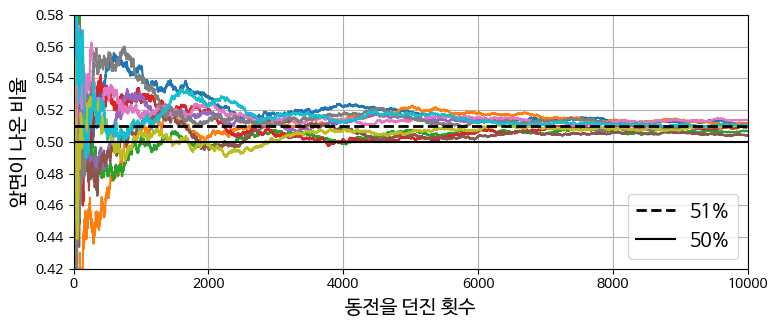

In [5]:
## 추가 코드 - 이 셀은 그림 7-3을 생성하고 저장합니다.

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

투표 기반 분류기를 만들어 보겠습니다:

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.score(X_test, y_test)

0.912

이제 간접 투표(soft voting)를 사용해 보겠습니다:   
개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## 배깅과 페이스팅
### 사이킷런의 배깅과 페이스팅

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
# 중복을 사용해서 100개씩 500번 실행

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

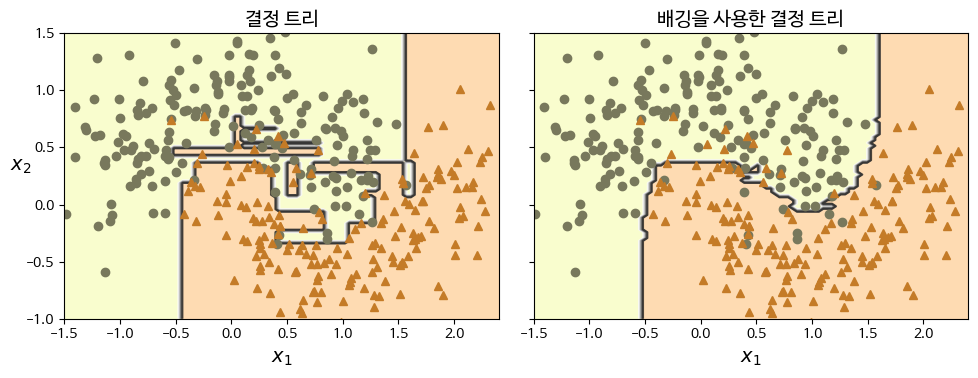

In [13]:
# 추가 코드 - 이 셀은 그림 7-5를 생성하고 저장합니다.

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("결정 트리")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("배깅을 사용한 결정 트리")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

중복을 허용해서 평균 63%만 샘플링  
OOB(out-of-bag) 샘플 - 선택되지 않은 나머지 대게 37%의 샘플 -> 이걸 평가할 때 사용함  

### OOB 평가

In [16]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [ ]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

크기가 _m_인 데이터셋에서 하나의 샘플을 무작위로 뽑는 경우, 데이터셋의 각 샘플이 선택될 확률은 1/_m_ 이므로 선택되지 않을 확률은 1 - 1/_m_ 입니다. 중복을 허용하여 _m_ 개의 샘플을 뽑는 경우, 모든 추첨은 독립적이므로 각 샘플의 선택되지 않을 확률은 (1 - 1/_m_)<sup>_m_</sup> 입니다. 이제 _m_ 이 무한대에 가까워지면 exp(_x_)가 (1 + _x_/_m_)<sup>_m_</sup>의 극한과 같다는 사실을 이용해 보겠습니다. 따라서 _m_ 이 크면 OOB 샘플의 비율은 약 exp(-1) ≈ 0.37이 됩니다. 따라서 대략 63%(1 - 0.37)가 샘플링됩니다.

In [ ]:
# 추가 코드 - 63% 확률을 계산하는 방법을 보여줍니다.
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


• 랜덤 패치 방식(random patches method)  
• 훈련 특성과 샘플을 모두 샘플링  
• 랜덤 서브스페이스 방식(random subspaces method)  
• 훈련 샘플을 모두 사용(bootstrap=False이고 max_samples=1.0으로 설정)  
• 특성을 샘플링(bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게설정)  
특성이 획일화   
• 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을낮춤    

# 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 같습니다:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# 추가 코드 - 예측이 동일한지 확인합니다.
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # 동일한 예측

True

## 특성 중요도

In [17]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


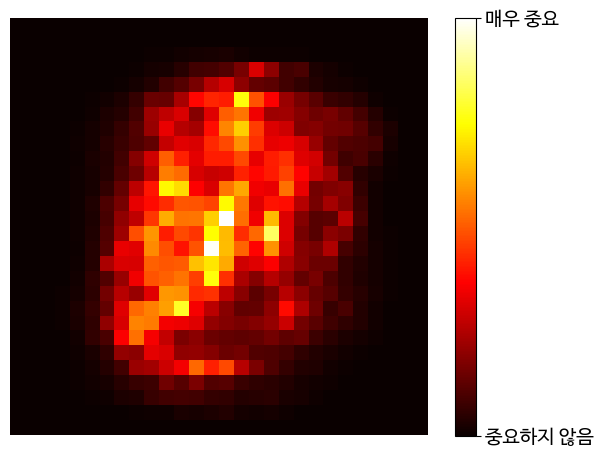

In [18]:
# 추가 코드 - 이 셀은 그림 7-6을 생성하고 저장합니다.

from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

## 부스팅
### AdaBoost 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임

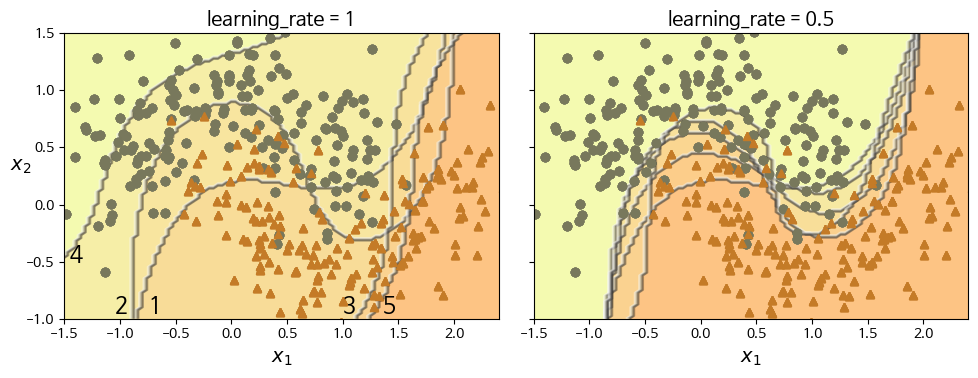

In [ ]:
# 추가 코드 - 이 셀은 그림 7-8을 생성하고 저장합니다.

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

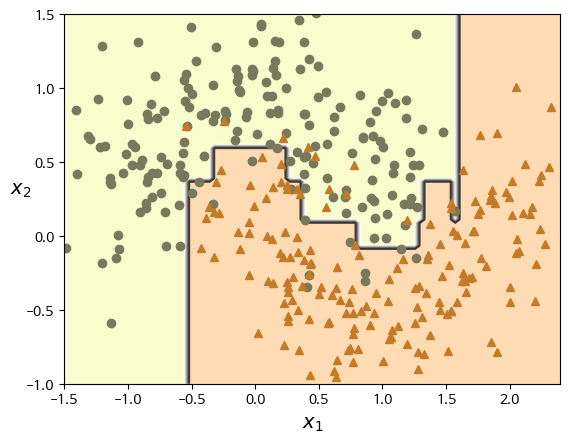

In [ ]:
# 추가 코드 - AdaBoost 분류기에 대한 결정 경계가 어떻게 보이는지 궁금한 경우
plot_decision_boundary(ada_clf, X_train, y_train)

### 그레이디언트 부스팅

간단한 2차방정식 데이터셋을 만들고 여기에 `DecisionTreeRegressor`를 훈련시켜 보겠습니다:

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 이전 예측기가 만든 잔여 오차에 대해 다른 결정 트리 회귀를 훈련해 보겠습니다:

In [24]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [25]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [26]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

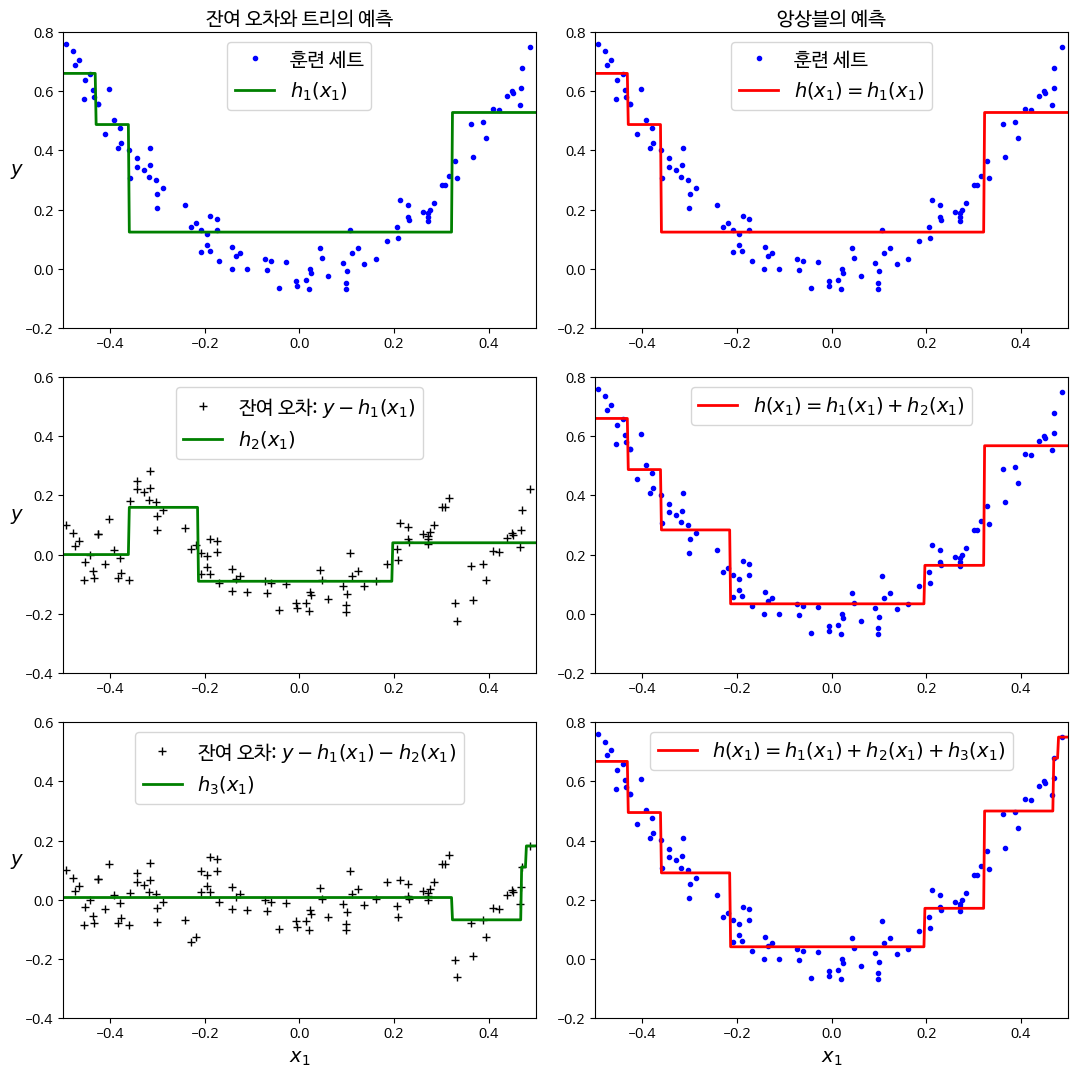

In [27]:
# 추가 코드 - 이 셀은 그림 7-9를 생성하고 저장합니다.

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀를 시도해 보겠습니다:

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [29]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42) # earlystopping 과 같음. 나아지지않으면 종료
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [30]:
gbrt_best.n_estimators_

92

축소(shrinkage)

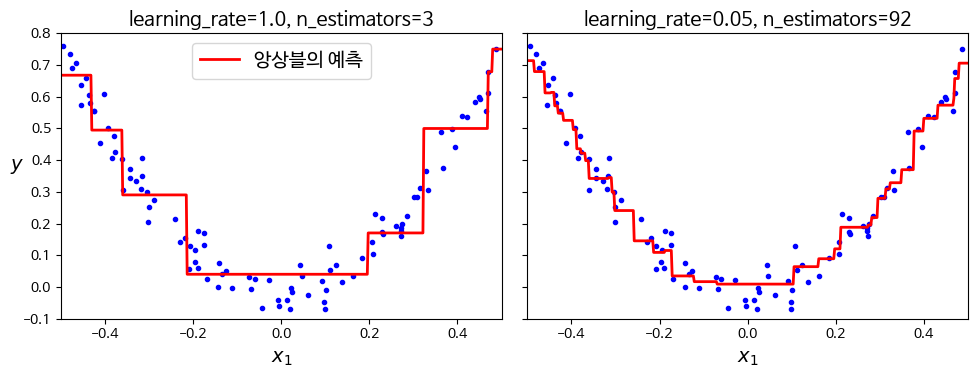

In [31]:
# 추가 코드 - 이 셀은 그림 7-10을 생성하고 저장합니다.

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="앙상블의 예측")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

In [32]:
# 추가 코드 - 2장에서 설명했습니다.

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [34]:
# 추가 코드 - hgb_reg 모델에 대한 RMSE 통계를 평가합니다.

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

,0
count,10.000000
mean,47613.307194
std,1295.422509
min,44963.213061
25%,47001.233485
50%,48000.963564
75%,48488.093243
max,49176.368465


## 스태킹
학습되면 기본 예측기는 전체 원본 훈련 세트로 마지막에 한 번
더 재훈련

In [35]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # 교차 검증 폴드 수 (횟수가 아닌 그림에서 예측기 수)
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [36]:
stacking_clf.score(X_test, y_test)

0.928

# 실습1
(3장에서 소개한) MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나누기(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플). 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법
을 사용해 앙상블로 연결해보기. 앙상블을 얻고 나면 테스트 세트로 확인. 개개의 분류기와 비교해서 성능이 얼마나 향상되나?

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞서 로드했습니다. 이 데이터셋은 이미 훈련 세트(처음 60,000개의 샘플)와 테스트 세트(마지막 10,000개의 샘플)로 분할되어 있으며, 훈련 세트는 이미 뒤섞여 있습니다. 따라서 처음 50,000개의 샘플을 새 훈련 세트에, 다음 10,000개의 샘플을 검증 세트에, 마지막 10,000개의 샘플을 테스트 세트에 사용하기만 하면 됩니다:

In [ ]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다._

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

사이킷런 1.5에서 `LinearSVC`의 `dual` 매개변수 기본값이 `True`에서 `"auto"`로 바뀔 예정입니다. 동일한 결과가 유지되도록 명시적으로 `True`로 지정합니다.

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("훈련 모델:", estimator)
    estimator.fit(X_train, y_train)

훈련 모델: RandomForestClassifier(random_state=42)
훈련 모델: ExtraTreesClassifier(random_state=42)
훈련 모델: LinearSVC(max_iter=100, random_state=42, tol=20)
훈련 모델: MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9613]

선형 SVM은 다른 분류기보다 성능이 훨씬 뛰어납니다. 하지만 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둡니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_valid, y_valid)

0.975

`VotingClassifier`는 각 분류기의 복제본을 만들어 원래 클래스 이름이 아닌 클래스 인덱스를 레이블로 사용하여 복제본을 훈련시켰습니다. 따라서 이러한 복제본을 평가하려면 클래스 인덱스도 제공해야 합니다. 클래스를 클래스 인덱스로 변환하기 위해 `LabelEncoder`를 사용할 수 있습니다:

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

그러나 MNIST의 경우 숫자가 클래스 ID와 일치하므로 클래스 이름을 정수로 변환하는 것이 더 간단합니다:

In [ ]:
y_valid_encoded = y_valid.astype(np.int64)

이제 분류기 복제본을 평가해 보겠습니다:

In [ ]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9613]

SVM을 제거하여 성능이 향상되는지 확인해 보겠습니다. 다음과 같이 `set_params()`를 사용하여 `"drop"`으로 설정하여 추정기를 제거할 수 있습니다:

In [ ]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

이렇게 하면 추정기 목록이 업데이트됩니다:

In [ ]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

그러나 _훈련된_ 추정기 목록은 업데이트하지 않습니다:

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [ ]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

따라서 `VotingClassifier`를 다시 훈련하거나 `estimators_`와 `named_estimators_`에 있는 훈련된 추정기 목록에서 SVM을 제거할 수 있습니다:

In [ ]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

이제 `VotingClassifier`를 다시 평가해 보겠습니다:

In [ ]:
voting_clf.score(X_valid, y_valid)

0.9761

조금 나아졌습니다! SVM이 성능을 저해하고 있었습니다. 이제 간접 투표 분류기를 사용해 보겠습니다. 실제로 분류기를 재학습할 필요 없이 `voting`를 `soft`로 설정하면 됩니다:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_valid, y_valid)

0.9703

이런, 이 경우에는 직접 투표 방식이 더 낫군요.

문제: _앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9733

In [ ]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9618]

투표 분류기는 최고 모델의 오류율을 약 3%에서 2.7%로 낮췄으며, 이는 10%의 오류를 줄인 것입니다.

# 실습2
실습1의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보기. 각 훈련 샘플은 하나
의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스. 새로운 훈련 세트에 분류기 하나를 훈련시켜
보기. 이제 테스트 세트에 앙상블을 평가. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만
들기 위해 블렌더에 그 예측을 주입. 앞서 만든 투표 분류기와 비교하면 어떤가?

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요._

In [ ]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [ ]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9738

이 블렌더를 미세 조정하거나 다른 유형의 블렌더(예: `MLPClassifier`)를 사용해 본 다음, 항상 그렇듯이 교차 검증을 통해 가장 적합한 블렌더를 선택할 수 있습니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다! 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
accuracy_score(y_test, y_pred)

0.9688

이 스태킹 앙상블은 앞서 학습한 투표 기반 분류기보다 성능이 좋지 않습니다.

문제: _이제 `StackingClassifier`를 사용하여 다시 시도해 보세요. 성능이 더 좋아졌나요? 그렇다면 그 이유는 무엇인가요?_

`StackingClassifier`는 K-겹 교차 검증을 사용하기 때문에 별도의 검증 세트가 필요하지 않으므로 훈련 세트와 검증 세트를 더 큰 훈련 세트로 합쳐보겠습니다:

In [ ]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

이제 전체 훈련 세트에서 스태킹 분류기를 생성하고 훈련해 보겠습니다:

**경고**: 다음 셀은 기본적으로 5-겹 검증을 사용하기 때문에 실행하는 데 시간이 꽤 오래 걸립니다(하드웨어에 따라 15~30분 정도 소요). 이 셀은 4개의 분류기를 전체 훈련 세트의 80%에 대해 각각 5회씩 훈련하여 예측을 하고, 마지막으로 전체 훈련 세트에 대해 각각 한 번씩 훈련하여 예측에 대한 최종 모델을 훈련합니다. 총 25개의 모델을 훈련해야 합니다!

In [ ]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [ ]:
stack_clf.score(X_test, y_test)

0.9788

`StackingClassifier`는 앞서 시도한 사용자 정의 스태킹 구현보다 훨씬 뛰어난 성능을 발휘합니다! 이는 크게 두 가지 이유 때문입니다:

* 검증 세트를 별도로 사용하지 않았기 때문에 더 큰 데이터 집합에 대해 `StackingClassifier`를 학습시켰습니다.
* 사용 가능한 경우 `predict_proba()`를, 그렇지 않으면 `decision_function()`을, 그렇지 않으면 `predict()`를 사용했습니다. 이렇게 하면 블렌더가 훨씬 더 미묘한 입력을 처리할 수 있습니다.

오늘은 여기까지입니다. 이 장의 코드와 연습 문제를 모두 완료하신 것을 축하드립니다!